Generating Training Data (SNR=7dB, N=100000)...
Training XGBoost Classifier...
Training Score: 0.9929
Calibrating Threshold for PFA = 0.0001...
Threshold set at probability: 0.970301
Testing PD across SNR range...


100%|██████████| 21/21 [01:13<00:00,  3.48s/it]


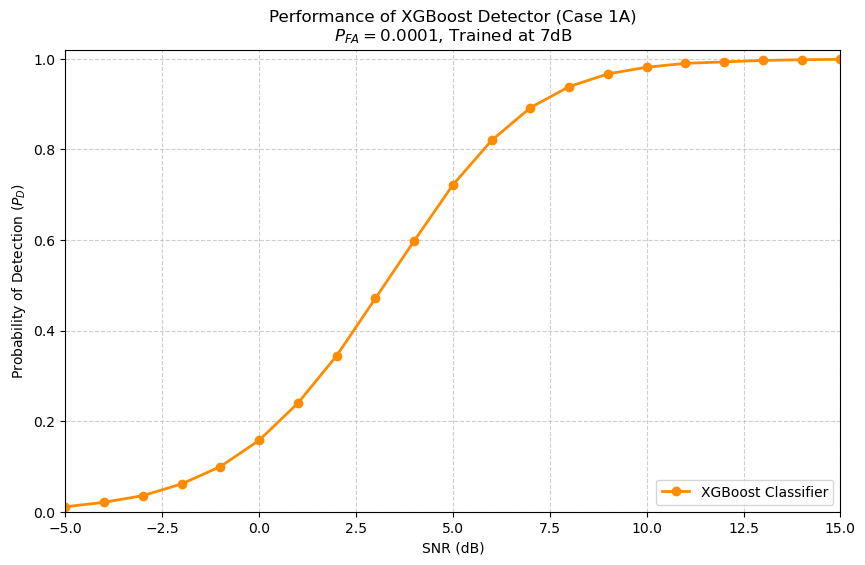


Simulation Complete.
Results (SNR, PD):
-5.0, 0.0108
-4.0, 0.0208
-3.0, 0.0355
-2.0, 0.0614
-1.0, 0.0997
0.0, 0.1577
1.0, 0.2397
2.0, 0.3444
3.0, 0.4711
4.0, 0.5980
5.0, 0.7216
6.0, 0.8199
7.0, 0.8920
8.0, 0.9386
9.0, 0.9666
10.0, 0.9813
11.0, 0.9899
12.0, 0.9931
13.0, 0.9963
14.0, 0.9980
15.0, 0.9987


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# --- Configuration ---
L_complex = 8         
L_real = 2 * L_complex 
TRAIN_SNR_dB = 7       # Training SNR
N_TRAIN = 100_000      # Large training set for tree boosting
N_H0_CALIBRATION = 1_000_000 # For precise PFA threshold
N_H1_TEST = 50_000     
PFA_TARGET = 1e-4      
SNR_RANGE_dB = np.linspace(-5, 15, 21)
noise_power = 1.0

# --- Helper Functions (Case 1A) ---

def generate_complex_gaussian(N_samples, Cov_matrix):
    L = Cov_matrix.shape[0]
    Re_C = Cov_matrix.real
    Im_C = Cov_matrix.imag
    Sigma = 0.5 * np.block([[Re_C, -Im_C], [Im_C, Re_C]])
    X_real = np.random.multivariate_normal(np.zeros(2 * L), Sigma, N_samples)
    Z_complex = X_real[:, :L] + 1j * X_real[:, L:]
    return Z_complex

def complex_to_real_inputs(Z_complex):
    N, L = Z_complex.shape
    X_real = np.zeros((N, 2 * L))
    X_real[:, ::2] = Z_complex.real
    X_real[:, 1::2] = Z_complex.imag
    return X_real

def generate_dataset_case1a(N_samples, snr_db, L_complex, noise_power):
    """Generates balanced Case 1A dataset (Train/Valid)."""
    snr_linear = 10**(snr_db / 10.0)
    signal_power = snr_linear * noise_power
    C_noise = noise_power * np.identity(L_complex)
    
    # Split
    N_H0 = N_samples // 2
    N_H1 = N_samples - N_H0

    # H0 (Noise)
    Z_H0 = generate_complex_gaussian(N_H0, C_noise)
    X_H0 = complex_to_real_inputs(Z_H0)
    y_H0 = np.zeros(N_H0)

    # H1 (Signal + Noise) - Unknown Correlation
    rho_t_samples = np.random.uniform(0, 1, N_H1)
    Z_H1 = np.zeros((N_H1, L_complex), dtype=complex)
    
    for i in range(N_H1):
        rho_t = rho_t_samples[i]
        indices = np.arange(L_complex)
        R_signal = rho_t**np.abs(indices[:, None] - indices[None, :])
        C_signal = signal_power * R_signal
        C_total = C_signal + C_noise
        Z_H1[i, :] = generate_complex_gaussian(1, C_total).flatten()
        
    X_H1 = complex_to_real_inputs(Z_H1)
    y_H1 = np.ones(N_H1)

    X = np.vstack([X_H0, X_H1])
    y = np.concatenate([y_H0, y_H1])
    idx = np.random.permutation(len(y))
    return X[idx], y[idx]

def generate_H1_only(N_samples, snr_db, L_complex, noise_power):
    """Generates only H1 samples for testing PD."""
    snr_linear = 10**(snr_db / 10.0)
    signal_power = snr_linear * noise_power
    C_noise = noise_power * np.identity(L_complex)
    
    rho_t_samples = np.random.uniform(0, 1, N_samples)
    Z_H1 = np.zeros((N_samples, L_complex), dtype=complex)
    
    for i in range(N_samples):
        rho_t = rho_t_samples[i]
        indices = np.arange(L_complex)
        R_signal = rho_t**np.abs(indices[:, None] - indices[None, :])
        C_signal = signal_power * R_signal
        C_total = C_signal + C_noise
        Z_H1[i, :] = generate_complex_gaussian(1, C_total).flatten()
        
    return complex_to_real_inputs(Z_H1)

def generate_H0_only(N_samples, L_complex, noise_power):
    """Generates only H0 samples for calibration."""
    C_noise = noise_power * np.identity(L_complex)
    Z_H0 = generate_complex_gaussian(N_samples, C_noise)
    return complex_to_real_inputs(Z_H0)

# --- XGBoost Model Setup ---

# 1. Generate Training Data
print(f"Generating Training Data (SNR={TRAIN_SNR_dB}dB, N={N_TRAIN})...")
X_train, y_train = generate_dataset_case1a(N_TRAIN, TRAIN_SNR_dB, L_complex, noise_power)

# 2. Configure and Train XGBoost
# Note: Deep trees (max_depth=8-10) help capture correlation between 16 inputs
print("Training XGBoost Classifier...")
xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=8,            # Deeper trees to capture feature interactions (correlation)
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic', # Similar to Cross-Entropy
    tree_method='hist',     # Fast histogram optimized training
    random_state=42,
    n_jobs=-1               # Use all CPU cores
)

xgb_model.fit(X_train, y_train)
print(f"Training Score: {xgb_model.score(X_train, y_train):.4f}")

# --- Threshold Calibration ---

print(f"Calibrating Threshold for PFA = {PFA_TARGET}...")
X_H0_cal = generate_H0_only(N_H0_CALIBRATION, L_complex, noise_power)

# Predict probabilities (class 1)
scores_H0 = xgb_model.predict_proba(X_H0_cal)[:, 1]

# Find threshold
threshold = np.percentile(scores_H0, 100 * (1 - PFA_TARGET))
print(f"Threshold set at probability: {threshold:.6f}")

# --- Testing Phase ---

pd_values = []
print(f"Testing PD across SNR range...")

for snr in tqdm(SNR_RANGE_dB):
    # Generate H1 samples for this SNR
    X_H1_test = generate_H1_only(N_H1_TEST, snr, L_complex, noise_power)
    
    # Predict
    scores_H1 = xgb_model.predict_proba(X_H1_test)[:, 1]
    
    # Calculate PD
    pd = np.sum(scores_H1 > threshold) / N_H1_TEST
    pd_values.append(pd)

# --- Plotting ---

plt.figure(figsize=(10, 6))
plt.plot(SNR_RANGE_dB, pd_values, label='XGBoost Classifier', color='darkorange', linewidth=2, marker='o')

# Setup plot aesthetics
plt.title(f'Performance of XGBoost Detector (Case 1A)\n$P_{{FA}}={PFA_TARGET}$, Trained at {TRAIN_SNR_dB}dB')
plt.xlabel('SNR (dB)')
plt.ylabel('Probability of Detection ($P_D$)')
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.legend(loc='lower right')
plt.xlim(min(SNR_RANGE_dB), max(SNR_RANGE_dB))
plt.ylim(0, 1.02)
plt.show()

print("\nSimulation Complete.")
print("Results (SNR, PD):")
for s, p in zip(SNR_RANGE_dB, pd_values):
    print(f"{s:.1f}, {p:.4f}")
